# Further testing of the sklearn pull request

In [1]:
__author__ = 'Nick Dingwall'

0. [Test of the warnings](#Test-of-the-warnings)
0. [Testing](#Testing)
  0. [Area calculation tests](#Area-calculation-tests)
  0. [Testing in the context of modelling](#Testing-in-the-context-of-modelling)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.metrics.base import _average_binary_score
from sklearn.metrics import precision_recall_curve
import warnings

import roam_average_precision as rap

matplotlib.style.use('../../src/roam.mplstyle')

In [3]:
y_true = [1,1,0,0,0,0,0,0,0]
y_const = 0.5 * np.ones(len(y_true))
y_rand = np.random.random(len(y_true))

## Test of the warnings

In [4]:
rap.average_precision_score(y_true, y_const)

/Users/nickdingwall/roam/base/roamresearch/BlogPosts/Average_precision/roam_average_precision.py:212: UserWarning: Number of unique scores is less than 75% of the number of scores provided. Linear interpolation is likely to be biased in this case. You may wish to use step interpolation instead. See docstring for details.
  warnings.warn("Number of unique scores is less than 75% of the "


0.61111111111111116

In [5]:
rap.average_precision_score(y_true, y_const, interpolation='step')

0.22222222222222221

In [6]:
rap.average_precision_score(y_true, y_rand)

0.12847222222222221

In [7]:
rap.average_precision_score(y_true, y_rand, interpolation='step')

0.19444444444444442

## Testing

The `measure_area` helper function so you can easily visualize arbitrary examples to try to find problems with the `auc` implementation. The caption tells you the area calculated using the same interpolation as in the figure.

In [8]:
def measure_area(x, y, **kwargs):
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    plot_area(ax, x, y, **kwargs)
    plt.show()
    
def plot_area(ax, x, y, 
              reorder=False, 
              interpolation=None, 
              interpolation_direction='right'):
    direction = 1
    if reorder:
        # reorder the data points according to the x axis and using y to
        # break ties
        order = np.lexsort((y, x))
        x, y = x[order], y[order]
    else:
        dx = np.diff(x)
        if np.any(dx < 0):
            if np.all(dx <= 0):
                direction = -1
            else:
                raise ValueError("Reordering is not turned on, and "
                                 "the x array is not increasing: %s" % x)
    ax.scatter(x, y, marker='o', linewidths=0, s=25)
    if interpolation == 'linear':
        x_long = x
        y_long = y
    
    elif interpolation == 'step':
        if direction == -1:
            x, y = list(reversed(x)), list(reversed(y))
        
        if interpolation_direction == 'right':
            y_long = [v for v in y for _ in (0, 1)][1:]
            x_long = [v for v in x for _ in (0, 1)][:-1]
        elif interpolation_direction == 'left':
            y_long = [v for v in y for _ in (0, 1)][:-1]
            x_long = [v for v in x for _ in (0, 1)][1:]            
        else:
            raise ValueError
    if max(x) < 1.1:
        ax.set_xticks(np.arange(-1, max(x)+1, 0.1))
    else:
        ax.set_xticks(np.arange(-1, max(x)+1, 1.0))
    if max(y) < 1.1:
        ax.set_yticks(np.arange(-1, max(y)+1, 0.1))
    else:
        ax.set_yticks(np.arange(-1, max(y)+1, 1.0))
        
    ax.plot(x_long, y_long)
    area = rap.auc(x, y, interpolation=interpolation, 
               interpolation_direction=interpolation_direction)
    ax.fill_between(x_long, 0, y_long, alpha=0.2, 
                    label='Area = {:5.4f}'.format(area))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

### Area calculation tests

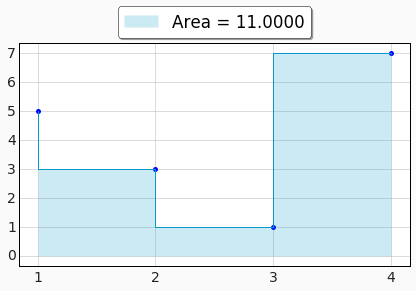

In [9]:
measure_area([1,2,3,4], [5,3,1,7], 
             interpolation='step', 
             interpolation_direction='right')

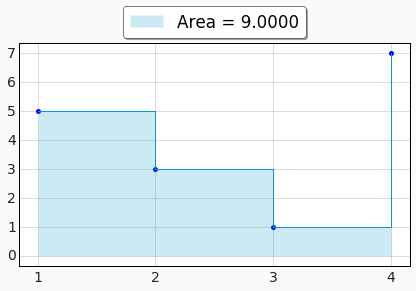

In [10]:
measure_area([1,2,3,4], [5,3,1,7], 
             interpolation='step', 
             interpolation_direction='left')

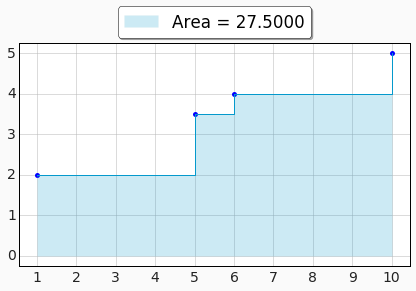

In [11]:
measure_area([1,5,6,10], [2, 3.5, 4, 5], 
             interpolation='step', 
             interpolation_direction='left')

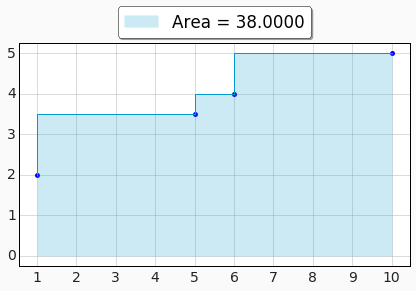

In [12]:
measure_area([1,5,6,10], [2, 3.5, 4, 5], 
             interpolation='step', 
             interpolation_direction='right')

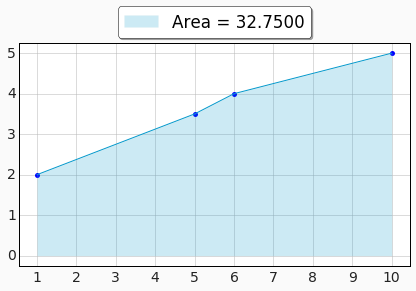

In [13]:
measure_area([1,5,6,10], [2, 3.5, 4, 5], 
             interpolation='linear')

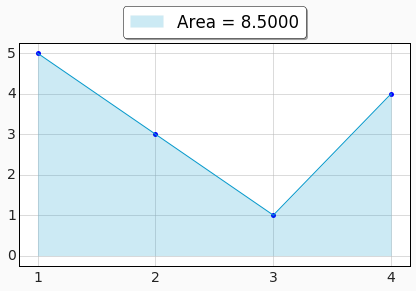

In [14]:
measure_area([1,2,3,4], [5,3,1,4], 
             interpolation='linear')

### Testing in the context of modelling

Now we want to make sure that this interpolation strategy makes sense in the context of precision, recall, and average precision (see [the main blog post notebook](Average_precision_post.ipynb) for details). The old sklearn-default 'linear' interpolation is on the left, and on the right is the new 'stepwise' interpolation.

In [15]:
def compare_interpolations_from_scores(y_true, y_score):
    p, r, _ = precision_recall_curve(y_true, y_score)
    compare_interpolations(r, p)
    
def compare_interpolations(x, y, **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    plot_area(ax[0], x, y, 
              interpolation='linear', 
              **kwargs)
    plot_area(ax[1], x, y, 
              interpolation='step', 
              interpolation_direction='right', 
              **kwargs)
    plt.show()

#### Constant score

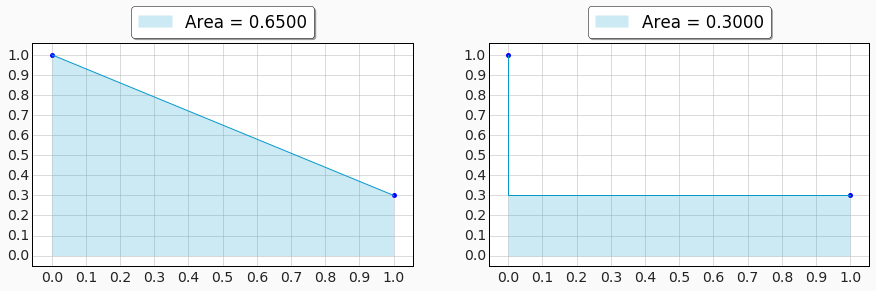

In [16]:
y_true = [1,1,1,0,0,0,0,0,0,0]
y_const = 0.5 * np.ones(len(y_true))
compare_interpolations_from_scores(y_true, y_const)

#### Random score

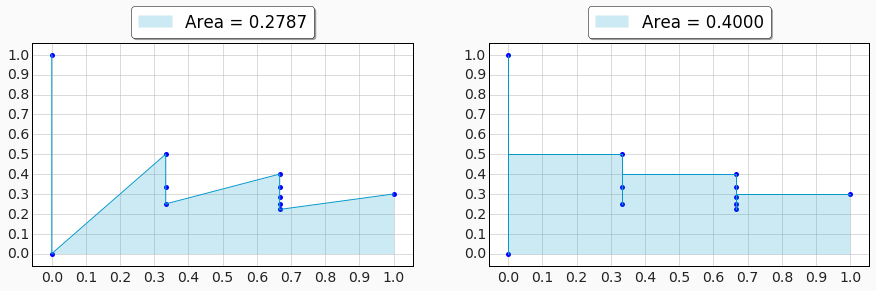

In [17]:
y_rand = np.random.random(len(y_true))
compare_interpolations_from_scores(y_true, y_rand)

#### Random score with more data

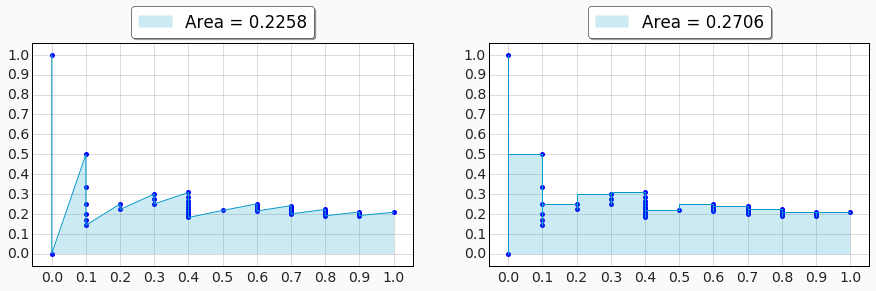

In [18]:
y_true = [1 for _ in range(10)] + [0 for _ in range(50)]
y_rand = np.random.random(len(y_true))
compare_interpolations_from_scores(y_true, y_rand)

#### Rounded versions of random score

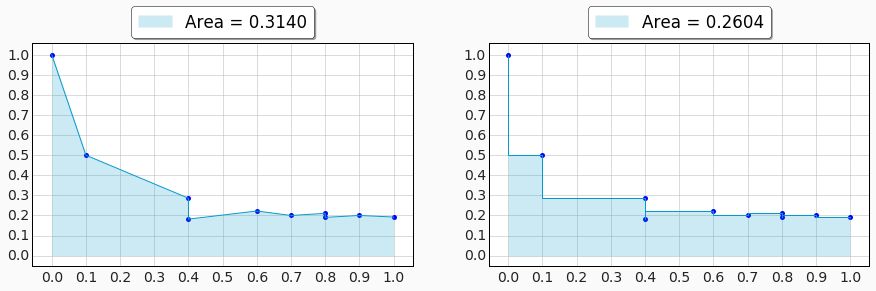

In [19]:
y_round = np.round(y_rand, 1)
compare_interpolations_from_scores(y_true, y_round)

####  Pretty good classifier

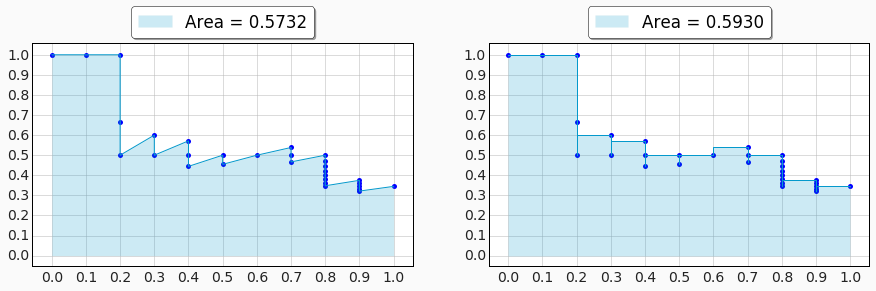

In [20]:
y_close = [np.random.normal(loc=i, scale=len(y_true)/3) for i in range(len(y_true), 0, -1)]
compare_interpolations_from_scores(y_true, y_close)

#### Lots more data with a good classifer

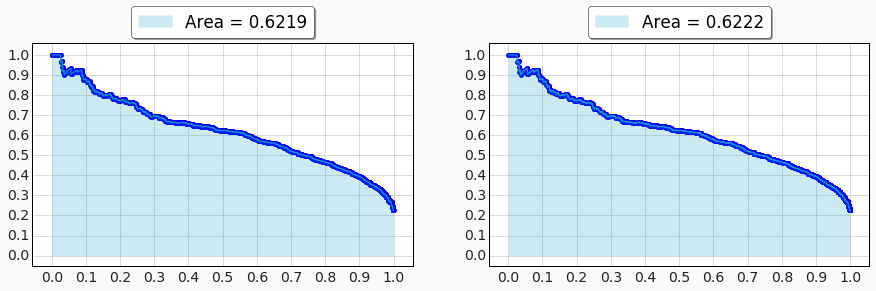

In [21]:
y_true = [1 for _ in range(1000)] + [0 for _ in range(10000)]
y_close = [np.random.normal(loc=i, scale=len(y_true)/8) 
           for i in range(len(y_true), 0, -1)]
compare_interpolations_from_scores(y_true, y_close)

#### The same data but this time we've rounded the scores

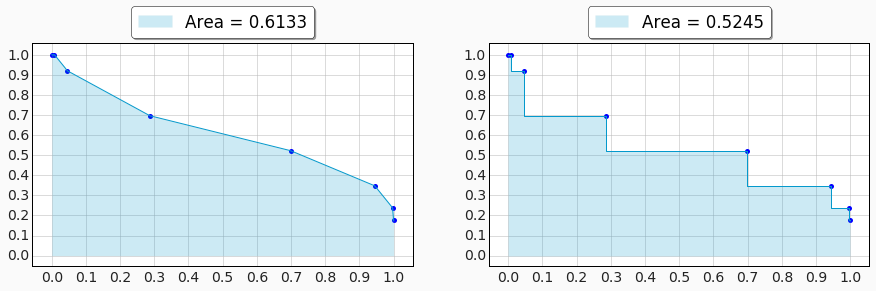

In [22]:
y_close_round = np.round(np.array(y_close) / max(y_close), 1)
compare_interpolations_from_scores(y_true, y_close_round)